# Purpose

Compare a GO Term's learnability via Composition-induced co-expression to its MGES

In [16]:
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [2]:
# Load learnability
path_to_learnability_file = "/space/grp/aadrian/Pseudobulk_Function_Pipeline_HighRes/bin/bulkSimulationOneProfile/data/boot_run_feb29/master_melted_df.csv.gz"


def load_learnability(path:str)->pd.DataFrame:
	"""Load a dataframe containing info about a GO term's learnability from composition-induced co-expression

	Args:
		path (str): file path

	Returns:
		pd.DataFrame: df
	"""
	GO_learnabilty_df = pd.read_csv(path,index_col=0)

	# extract and drop some metadata columns
	GO_learnabilty_df['exp_type'] = GO_learnabilty_df.organism_part.str.split("_").str.get(0)
	GO_learnabilty_df['tissue'] = GO_learnabilty_df.organism_part.str.split("_").str.get(1)
	GO_learnabilty_df = GO_learnabilty_df[GO_learnabilty_df.loc[:,'variance']==0.05]
	GO_learnabilty_df.drop('organism_part', axis =1 , inplace=True)
	GO_learnabilty_df.drop('variance', axis =1 , inplace=True)

	return GO_learnabilty_df

GO_learnabilty_df = load_learnability(path_to_learnability_file)
GO_learnabilty_df.head()


,index,bootstrap,auc,exp_type,tissue
1397,GO:0000045,3,0.522443,cntrl,brain
1398,GO:0000070,3,0.504677,cntrl,brain
1399,GO:0000077,3,0.468358,cntrl,brain
1400,GO:0000079,3,0.498369,cntrl,brain
1401,GO:0000082,3,0.520443,cntrl,brain


# Load MGES scores

In [62]:

def load_mges_scores(mges_path:str, mgesname:str)->pd.DataFrame:
	"""Load MGES dictionary

	Args:
		mges_path (str): path to dict
		mgesname (str): name of MGES type (Brain or PBMC)

	Returns:
		pd.DataFrame: has GO term and term's MGES score
	"""
	# Load the JSON file into a dictionary
	with open(mges_path, 'r') as json_file:
		mges = json.load(json_file)
	
	# Convert the dictionary to a DataFrame
	mges = pd.DataFrame(list(mges.items()), columns=['GO', mgesname])
	
	return mges

brain_mges = load_mges_scores("../MGES/data/brain_mges.json", 'brainMGES')
pbmc_mges = load_mges_scores("../MGES/data/pbmc_mges.json", 'pbmcMGES')


# Merge Learnability with GO MGES scores

In [4]:
master_GO_learnability_df = GO_learnabilty_df.merge(mges, left_on='index', right_on='GO')
master_GO_learnability_df.head()

,index,bootstrap,auc,exp_type,tissue,GO,brainMGES,pbmcMGES
0,GO:0000045,3,0.522443,cntrl,brain,GO:0000045,0.054548,0.007544
1,GO:0000045,3,0.537387,exp,brain,GO:0000045,0.054548,0.007544
2,GO:0000045,1,0.562481,exp,pbmc,GO:0000045,0.054548,0.007544
3,GO:0000045,2,0.589985,exp,pbmc,GO:0000045,0.054548,0.007544
4,GO:0000045,5,0.503032,cntrl,pbmc,GO:0000045,0.054548,0.007544


# Graph MGES vs Learnability for Brain

In [5]:
# Group by the specified columns
grouped = master_GO_learnability_df.groupby(['index', 'exp_type','tissue'])

# Aggregate the grouped data
aggregated_df = grouped.agg({
    'auc': 'mean',
    'brainMGES': 'mean',
    'pbmcMGES': 'mean'
}).reset_index()
aggregated_df.head()

,index,exp_type,tissue,auc,brainMGES,pbmcMGES
0,GO:0000045,cntrl,brain,0.495079,0.054548,0.007544
1,GO:0000045,cntrl,pbmc,0.485234,0.054548,0.007544
2,GO:0000045,exp,brain,0.545295,0.054548,0.007544
3,GO:0000045,exp,pbmc,0.561590,0.054548,0.007544
4,GO:0000070,cntrl,brain,0.505884,0.012181,0.000910


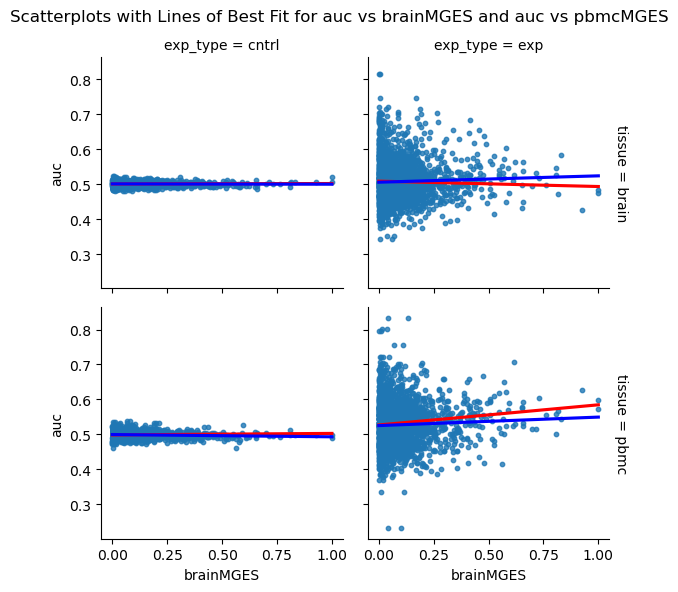

In [6]:
# Assuming brain_master is your DataFrame
# Create a seaborn FacetGrid
g = sns.FacetGrid(aggregated_df, row='tissue', col='exp_type', margin_titles=True)

# Map the scatterplot with line of best fit for 'auc' vs 'pbmcMGES'
g.map(sns.regplot, 'pbmcMGES', 'auc', scatter_kws={'s':10}, line_kws={'color':'red'}, ci=None)
# Map the scatterplot with line of best fit for 'auc' vs 'brainMGES'
g.map(sns.regplot, 'brainMGES', 'auc', scatter_kws={'s':10}, line_kws={'color':'blue'}, ci=None)

# Add legends and adjust the plot
g.add_legend()
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Scatterplots with Lines of Best Fit for auc vs brainMGES and auc vs pbmcMGES')

# Show the plot
plt.show()

# Regress out Composition Effect

And show that correlation between MGES and GO learnability decreases

In [7]:
import pandas as pd

In [86]:
# Load df for GO learnability from brain with MGES regressed
def load_regressed_performance(path = "/space/grp/aadrian/Pseudobulk_Function_Pipeline_HighRes/bin/deconvolutingBulk/data/dev/july_boot_29")->pd.DataFrame:
    """Loads performance from 62 simulations where composition variance from brain markers was regressed out

    Args:
        path (str, optional): path to regression performance directory

    Returns:
        pd.DataFrame: Dataframe that has performance for bulk brain with regressed comp
    """

    lo_dirs = os.listdir(path)
    lo_potential_files = [f"{path}/{dir}/melted_EGAD.csv" for dir in lo_dirs]

    def filter_existing_paths(paths):
        """Filter out paths that do not exist."""
        existing_paths = [path for path in paths if os.path.exists(path)]
        return existing_paths
    lo_files = filter_existing_paths(lo_potential_files)
    
    lo_dfs = [pd.read_csv(file, index_col=0) for file in lo_files]

    def add_boot_col(lo_dfs):
        lo_new_dfs = []
        for i,df in enumerate(lo_dfs):
            df['boot']=i
            lo_new_dfs.append(df)
        return lo_new_dfs
    lo_dfs = add_boot_col(lo_dfs=lo_dfs)
    
    df = pd.concat(lo_dfs, axis = 0)
    # df_grouped = df.reset_index().groupby(by = ['index', 'tissue', 'type'])['auc'].mean().reset_index()
    return df #df_grouped

df_no_comp_effects = load_regressed_performance()
agg_no_comp = df_no_comp_effects.loc[:,['auc','type']].reset_index().groupby(['index','type']).mean().reset_index() # aggragate over repeats
agg_no_comp.head()

,index,type,auc
0,GO:0000045,markers,0.535564
1,GO:0000045,random,0.547717
2,GO:0000070,markers,0.666578
3,GO:0000070,random,0.692279
4,GO:0000077,markers,0.566519


In [87]:
brain_mges = load_mges_scores("../MGES/data/brain_mges.json", 'brainMGES')
pbmc_mges = load_mges_scores("../MGES/data/pbmc_mges.json", 'pbmcMGES')
mges_all = pd.merge(brain_mges, pbmc_mges, on="GO")

In [88]:
# build merged df
reg_merged = pd.merge(mges_all, agg_no_comp, left_on="GO", right_on="index")
reg_merged.head()

,GO,brainMGES,pbmcMGES,index,type,auc
0,GO:0000045,0.054548,0.007544,GO:0000045,markers,0.535564
1,GO:0000045,0.054548,0.007544,GO:0000045,random,0.547717
2,GO:0000070,0.012181,0.000910,GO:0000070,markers,0.666578
3,GO:0000070,0.012181,0.000910,GO:0000070,random,0.692279
4,GO:0000077,0.036833,0.002620,GO:0000077,markers,0.566519


In [89]:
pivoted = reg_merged.pivot(index=['GO','brainMGES','pbmcMGES'], columns='type',values='auc')
pivoted['random-markers']=pivoted['random']-pivoted['markers']
pivoted=pivoted.reset_index()
pivoted =  pivoted.melt(id_vars=['GO','random-markers'], value_vars=['brainMGES', 'pbmcMGES'], 
                       var_name='Sample', value_name='MGES_Value')
pivoted.head()

,GO,random-markers,Sample,MGES_Value
0,GO:0000045,0.012153,brainMGES,0.054548
1,GO:0000070,0.025701,brainMGES,0.012181
2,GO:0000077,-0.030742,brainMGES,0.036833
3,GO:0000079,-0.047068,brainMGES,0.035272
4,GO:0000082,-0.022597,brainMGES,0.081705


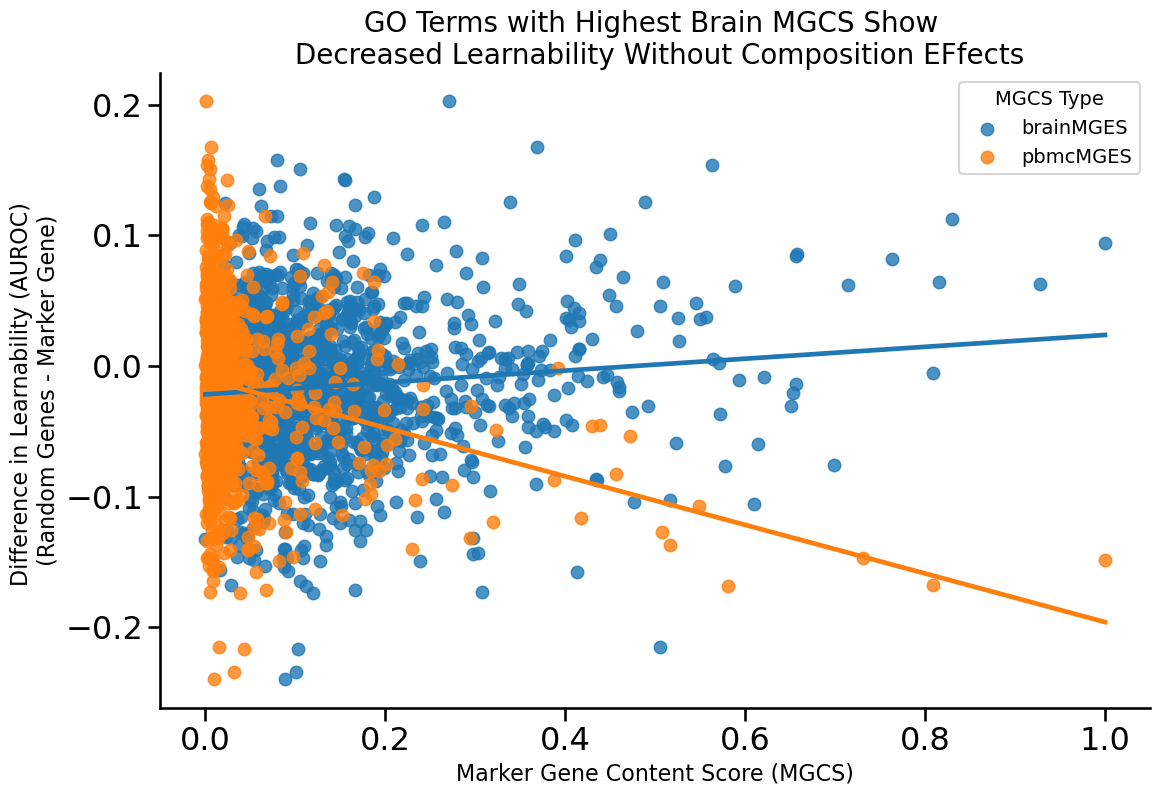

In [113]:
sns.lmplot(pivoted, x = 'MGES_Value', y = 'random-markers', hue='Sample', legend=None, height=8, aspect=1.5, ci = None)
# Add title and labels
plt.title('GO Terms with Highest Brain MGCS Show \n Decreased Learnability Without Composition EFfects', fontsize=20)
plt.xlabel('Marker Gene Content Score (MGCS)', fontsize=16)
plt.ylabel('Difference in Learnability (AUROC) \n (Random Genes - Marker Gene) ', fontsize=16)

# Add legend with increased font size
plt.legend(title='MGCS Type', title_fontsize='14', fontsize='14')

# Show plot
plt.show()